In [53]:
from __future__ import division
import pandas as pd
import numpy as np
import random
import math
import scipy.stats as sps

In [54]:
import warnings
warnings.filterwarnings('ignore')

In [55]:
df = pd.read_csv('mushrooms.csv')
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [56]:
df.shape

(8124, 23)

In [57]:
### pass array as series of pandas 
def entropy(array):
    entropy_total = 0
    values = array.unique()
    #print(values)
    for value in values:
        fraction = float(array.value_counts()[value]/array.shape[0])
        #print(fraction)
        entropy_total += -fraction*np.log2(fraction)
    return entropy_total
    

In [58]:
def information_gain(data,split_attribute_name,target_name="class"):
    total_entropy = entropy(data[target_name])
    vals,counts= np.unique(data[split_attribute_name],return_counts=True)
    Weighted_Entropy = np.sum([(counts[i]/np.sum(counts))*entropy(data.where(data[split_attribute_name]==vals[i]).dropna()[target_name]) for i in range(len(vals))])
    Information_Gain = total_entropy - Weighted_Entropy
    return Information_Gain

In [59]:
def ID3(data,originaldata,features,target_attribute_name="class",previous_mode = None):
        
    if len(np.unique(data[target_attribute_name])) <= 1:
        return np.unique(data[target_attribute_name])[0]
    
    elif len(data)==0:
        return np.unique(originaldata[target_attribute_name])[np.argmax(np.unique(originaldata[target_attribute_name],return_counts=True)[1])]
    
    elif len(features) ==0:
        return previous_mode
        
    else:
        ## calculate mode
        previous_mode = np.unique(data[target_attribute_name])[np.argmax(np.unique(data[target_attribute_name],return_counts=True)[1])]
        
        ###subspace sampling
        data = data.sample(frac=0.8,replace=True)

        
        ##random selection of features
        features = np.random.choice(features,size=np.int(np.sqrt(len(features))),replace=False)
        
        ## best feature selection
        item_values = [information_gain(data,feature,target_attribute_name) for feature in features] #Return the information gain values for the features in the dataset
        best_feature_index = np.argmax(item_values)
        best_feature = features[best_feature_index]
        
        
        tree = {best_feature:{}}
        
        
        #removing best feature
        features = [i for i in features if i != best_feature]
        
        #root node will have no. of child node as much unique values in best feature 
        
        for value in np.unique(data[best_feature]):
            value = value
            sub_data = data.where(data[best_feature] == value).dropna()
            
            #recursion
            subtree = ID3(sub_data,originaldata,features,target_attribute_name,previous_mode)
            #printing tree structure purpose
            tree[best_feature][value] = subtree
            
        return(tree)    

In [60]:
def predict(query,tree,default = 'p'):
        
    for key in list(query.keys()):
        if key in list(tree.keys()):
            try:
                result = tree[key][query[key]] 
            except:
                return default
            result = tree[key][query[key]]
            if isinstance(result,dict):
                return predict(query,result)
            else:
                return result

In [66]:
def train_test_split(dataset):
    training_data = dataset.iloc[:int(round(0.75*len(dataset)))].reset_index(drop=True)#We drop the index respectively relabel the index
    #starting form 0, because we do not want to run into errors regarding the row labels / indexes
    testing_data = dataset.iloc[int(round(0.75*len(dataset))):].reset_index(drop=True)
    return training_data,testing_data


In [67]:
def RandomForest_Train(dataset,number_of_Trees):
    #Create a list in which the single forests are stored
    random_forest_sub_tree = []
    
    #Create a number of n models
    for i in range(number_of_Trees):
        #Create a number of bootstrap sampled datasets from the original dataset 
        bootstrap_sample = dataset.sample(frac=1,replace=True)
        
        #Create a training and a testing datset by calling the train_test_split function
        bootstrap_training_data = train_test_split(bootstrap_sample)[0]
        bootstrap_testing_data = train_test_split(bootstrap_sample)[1] 
        
        
        #Grow a tree model for each of the training data
        #We implement the subspace sampling in the ID3 algorithm itself. Hence take a look at the ID3 algorithm above!
        random_forest_sub_tree.append(ID3(bootstrap_training_data,bootstrap_training_data,bootstrap_training_data.drop(labels=['class'],axis=1).columns))
        
    return random_forest_sub_tree

In [69]:
#######Predict a new query instance###########
def RandomForest_Predict(query,random_forest,default='p'):
    predictions = []
    for tree in random_forest:
        predictions.append(predict(query,tree,default))
    return sps.mode(predictions)[0][0]
query = testing_data.iloc[0,:].drop('class').to_dict()
query_target = testing_data.iloc[0,0]
#print('class: ',query_target)
prediction = RandomForest_Predict(query,random_forest)
#print('prediction: ',prediction)


#######Test the model on the testing data and return the accuracy###########
def RandomForest_Test(data,random_forest):
    data['predictions'] = None
    for i in range(len(data)):
        query = data.iloc[i,:].drop('class').to_dict()
        data.loc[i,'predictions'] = RandomForest_Predict(query,random_forest,default='p')
    accuracy = sum(data['predictions'] == data['class'])/len(data)*100
    #print('The prediction accuracy is: ',sum(data['predictions'] == data['target'])/len(data)*100,'%')
    return accuracy

In [75]:
training_data , testing_data= train_test_split(df)
random_forest = RandomForest_Train(training_data,10)
RandomForest_Test(testing_data,random_forest)

74.88921713441654

In [90]:
random_forest[7]

{'spore-print-color': {'b': 'e',
  'h': {'stalk-color-above-ring': {'b': 'p', 'n': 'p', 'p': 'p', 'w': 'p'}},
  'k': {'population': {'a': 'e', 'n': 'e', 's': 'e', 'v': 'e', 'y': 'e'}},
  'n': {'population': {'a': 'e',
    'c': 'e',
    'n': 'e',
    's': 'e',
    'v': 'e',
    'y': 'e'}},
  'o': 'e',
  'r': 'p',
  'u': 'e',
  'w': {'stalk-color-above-ring': {'c': 'p',
    'e': 'e',
    'n': 'e',
    'p': 'p',
    'w': 'p',
    'y': 'p'}},
  'y': 'e'}}

## Plot of Accuracy vs No. of trees

In [76]:
dataset = df
accuracy = []
for i in range(1,11,1):
    random_forest = RandomForest_Train(dataset,i)
    accuracy.append(RandomForest_Test(testing_data,random_forest))
print(accuracy)

[83.50566223535203, 54.505169867060566, 100.0, 63.8109305760709, 100.0, 98.96602658788774, 93.89463318562285, 100.0, 99.21221073362875, 89.80797636632201]


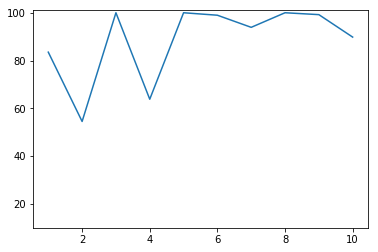

In [80]:
%matplotlib inline
plt.plot(range(11)[1:], accuracy)
plt.ylim(10,101)
plt.show()